<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Network_Base_Model_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyod --quiet

In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
replace /content/SWaT_Dataset_Attack_v0.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit
from sklearn.metrics import confusion_matrix

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

In [13]:
train_df.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [14]:
P1 = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']

In [15]:
train_p1 = train_scale[P1]
test_p1 = test_scale[P1]

Model tuning

In [16]:
from  pyod.models.deep_svdd import DeepSVDD
model1 = DeepSVDD(preprocessing = False,epochs=10, batch_size =64, hidden_neurons= [64, 32], use_ae=True)
model2 = DeepSVDD(preprocessing = False,epochs=10, batch_size =64, hidden_neurons= [64, 32], use_ae=False)

In [17]:
model1.fit(train_scale)
model2.fit(train_scale)

14850/14850 [==============================] - 21s 1ms/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 64)           3264        ['input_2[0][0]']                
                                                                                                  
 net_output (Dense)             (None, 32)           2048        ['dense_4[0][0]']                
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 32)          0           ['net_output[0][0]']             
 )                              

DeepSVDD(batch_size=64,
     c=array([0.1    , 0.1    , 0.35358, 0.46229, 0.1    , 0.19627, 0.1    ,
       0.1    , 0.1    , 0.11819, 0.1    , 0.1    , 0.1    , 0.1    ,
       0.1    , 0.1    , 0.16594, 0.     , 0.1    , 0.17724, 0.1    ,
       0.1    , 0.37647, 0.1    , 0.14767, 0.     , 0.35353, 0.1    ,
       0.22782, 0.1    , 0.78481, 0.     ], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=10,
     hidden_activation='relu', hidden_neurons=[64, 32], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=False,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)

In [18]:
loss1 = model1.history_
loss2 = model2.history_

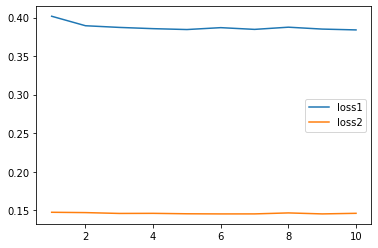

In [19]:
plt.plot(np.arange(1,11), loss1['val_loss'])
plt.plot(np.arange(1,11), loss2['val_loss'])
plt.legend(['loss1','loss2'])

In [20]:
model3 = DeepSVDD(preprocessing = False,epochs=10, batch_size =64, hidden_neurons= [128, 64], use_ae=False)
model4 = DeepSVDD(preprocessing = False,epochs=10, batch_size =128, hidden_neurons= [64, 32], use_ae=False)
model5 = DeepSVDD(preprocessing = False,epochs=10, batch_size =128, hidden_neurons= [128, 64], use_ae=False)

In [21]:
model3.fit(train_scale)
model4.fit(train_scale)
model5.fit(train_scale)

14850/14850 [==============================] - 17s 1ms/step
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 51)]              0         
                                                                 
 dense_11 (Dense)            (None, 128)               6528      
                                                                 
 net_output (Dense)          (None, 64)                8192      
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 64)               0         
 bda)                                                            
                                                                 
 tf.math.pow_5 (TFOpLambda)  (None, 64)                0         
                                                                 
 tf.math.reduce_sum_5 (TFOpL  (None,)                  0         

DeepSVDD(batch_size=128,
     c=array([0.17148, 0.11408, 0.36289, 0.1    , 0.32472, 0.1    , 0.1    ,
       0.1    , 0.1    , 0.1    , 0.25865, 0.14603, 0.26543, 0.1    ,
       0.1    , 0.29562, 0.1    , 0.1    , 0.1    , 0.     , 0.30585,
       0.1    , 0.1    , 0.1    , 0.1    , 0.22789, 0.55861, 0.1    ,
       0.1    , 0....      0.1    , 0.36406, 0.1    , 0.1    , 0.16001, 0.1    , 0.1    ,
       0.     ], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=10,
     hidden_activation='relu', hidden_neurons=[128, 64],
     l2_regularizer=0.1, optimizer='adam', output_activation='sigmoid',
     preprocessing=False, random_state=None, use_ae=False,
     validation_size=0.1, verbose=1)

In [22]:
loss3 = model3.history_
loss4 = model4.history_
loss5 = model5.history_

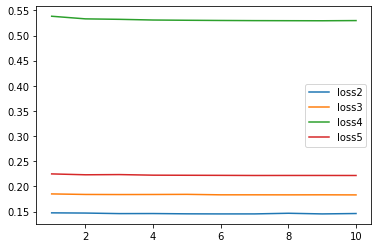

In [23]:
plt.plot(np.arange(1,11), loss2['val_loss'])
plt.plot(np.arange(1,11), loss3['val_loss'])
plt.plot(np.arange(1,11), loss4['val_loss'])
plt.plot(np.arange(1,11), loss5['val_loss'])
plt.legend(['loss2','loss3','loss4','loss5'])

model 2 has the lowest validation loss

setting: batch_size =64, hidden_neurons= [64, 32], use_ae=False